In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mne.io import Raw
from pandas import DataFrame, concat
from statsmodels.api import OLS
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_conds = {r'$EO_1$':[2, 4, 8],
             r'$EO_2$':[12, 14],
             r'$EC_1$':[3, 5, 9],
             r'$EC_2$':[13, 15]}

## Spectral parameters.
alpha_lim = (8, 12)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

trials, PSDs = [], []
for desc, files in eeg_conds.items():
    
    for f in files:
        
        ## Load and extract power data.
        npz = np.load('ave/eeg%0.2d.npz' %f)
        psds = npz['psds']
        freqs = npz['freqs'].round()
        
        ## Convert PSD to DataFrame. Append.
        psds = DataFrame(psds, columns=freqs)
        psds['Description'] = desc
        PSDs.append(psds)
        
## Concatenate PSD DataFrames.  
PSDs = concat(PSDs)
PSDs['Trial'] = np.arange(PSDs.shape[0])
PSDs = PSDs.melt(id_vars=('Description','Trial'), var_name='Freq', value_name='dB')

## Make alpha-only DataFrame.
alpha = PSDs[np.logical_and(PSDs.Freq >= alpha_lim[0], PSDs.Freq <= alpha_lim[1])]
alpha = alpha.groupby(['Description','Trial']).mean().reset_index()

## Clarify metadata.
for df in [PSDs, alpha]:
    df['Condition'] = df['Description'].apply(lambda x: x[1:3])
    df['Session'] = df['Description'].apply(lambda x: x[-2])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Modify alpha DataFrame for OLS.
_, alpha['A'] = np.unique(alpha.Condition, return_inverse=True)
_, alpha['B'] = np.unique(alpha.Session, return_inverse=True)

## Fit model.
result = OLS.from_formula('dB ~ A * B', data=alpha).fit()
result.summary()

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dB   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     991.5
Date:                Fri, 13 Oct 2017   Prob (F-statistic):          2.88e-239
Time:                        17:12:00   Log-Likelihood:                -1452.3
No. Observations:                 640   AIC:                             2913.
Df Residuals:                     636   BIC:                             2930.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -81.9271      0.182   -449.607      0.000     -82.285     -81.569
A            -10.6764      0.244    -43.694      0.000     -11.156     -10.197
B              0.5774      0.294      1.966      0.050       0.001       1.154
A:B            1.1090      0.383      2.895      0.004       0.357       1.861
==============================================================================
Omnibus:                       11.800   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.388
Skew:                           0.250   Prob(JB):                      0.00124
Kurtosis:                       3.502   Cond. No.                         7.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


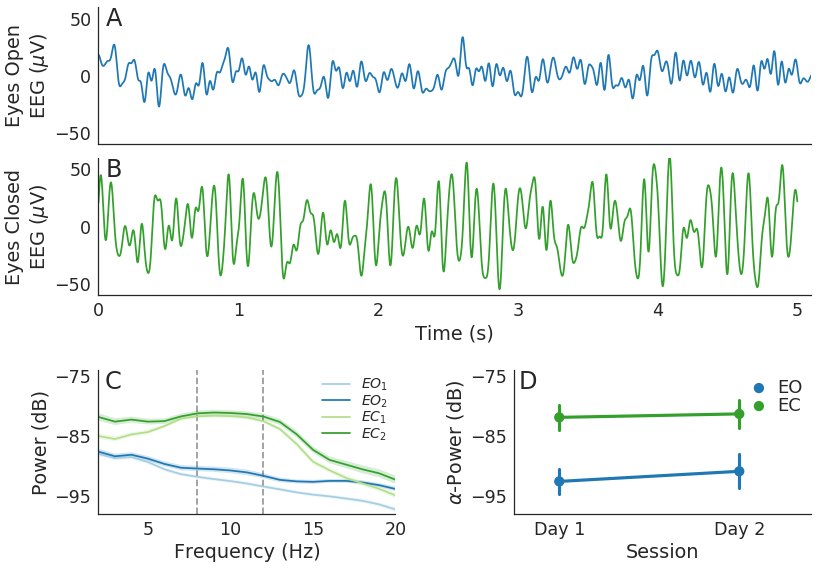

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Open canvas for plotting.
fig = plt.figure(figsize=(12,8))

## Plot representative timecourses.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.125, right=0.95, bottom=0.48,  top=0.98, hspace=0.1)

for n, f, text, color, label in zip(range(2), ['raw/eeg12_raw.fif', 'raw/eeg13_raw.fif'], ['A','B'],
                                    ['#1f78b4','#33a02c'], ['Eyes Open', 'Eyes Closed']):
    
    ## Load, filter, and extract data.
    raw = Raw(f, preload=True, verbose=False)
    raw = raw.filter(1, 20)
    data, times = raw.get_data(start=raw.time_as_index(25)[0], stop=raw.time_as_index(30)[0], return_times=True)

    ## Post-processing.
    data -= data.mean()
    times = times.copy() - times.min()

    ## Plotting.
    ax = plt.subplot(gs[n])
    ax.plot(times, data.squeeze() * 1e6, color=color, label=label)
    ax.set(xlim=(times.min(), times.max()), xticks=[], ylim=(-60,60), yticks=[-50,0,50], ylabel='%s\n' %label + r'EEG ($\mu$V)')
    ax.text(0.05, 60, text, va='top', ha='left', fontsize=24)

ax.set(xlim=(times.min(), times.max()+1e-1), xticks=[0,1,2,3,4,5], xlabel='Time (s)')

## Plot power density information.
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.125, right=0.95, bottom=0.1, top=0.35, hspace=0.0, wspace=0.4)

ax = plt.subplot(gs[0])
sns.tsplot(PSDs, time='Freq', unit='Trial', condition='Description', value='dB', 
           color=sns.color_palette('Paired',n_colors=4), ci=95, ax=ax)

ax.vlines(alpha_lim, -98, -74, linestyle='--', alpha=0.4)
ax.set(xlabel='Frequency (Hz)', ylim=(-98,-74), yticks=[-75, -85, -95], ylabel='Power (dB)')
ax.legend(loc=1, fontsize=14, borderpad=0, labelspacing=0)
ax.text(2.4, -74, 'C', va='top', ha='left', fontsize=24)

## Plot alpha power.
ax = plt.subplot(gs[1])
sns.pointplot('Session', 'dB', 'Condition', data=alpha, palette=['#33a02c', '#1f78b4'], ci='sd', ax=ax)
ax.set(xticklabels=['Day 1', 'Day 2'], xlim=(-0.25,1.4), ylim=(-98,-74), yticks=[-75, -85, -95], ylabel=r'$\alpha$-Power (dB)')
ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=1, borderpad=0, labelspacing=0, handletextpad=0, fontsize=18)
ax.text(-0.225, -74, 'D', va='top', ha='left', fontsize=24)

sns.despine()
plt.savefig('eeg.png', dpi=300)